## Notebook for analysis of Spam-Ham dataset and developing an ML model for further integration.

### Imports

In [143]:
# For analysis and handling data
import numpy as np
import pandas as pd

# For graphing
import matplotlib.pyplot as plt
import seaborn as sns

# For searching
import re

# For handling textual dataset
import nltk

# For making train and test splits
from sklearn.model_selection import train_test_split

# For removing the stopwords
from nltk.corpus import stopwords

# For removeing the suffixes from an English word and obtain its stem
from nltk.stem.porter import PorterStemmer

# For converting a collection of text documents into a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer

# Actual ML models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier

# For metrics and evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score

# For mulitset and counting operations
from collections import Counter

### Reading data and some pre-formatting

In [144]:
data = pd.read_csv("spam.csv", encoding = 'latin1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [145]:
# drop unavailable attributes
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

# rename columns 
data = data.rename(columns ={"v1":"target", "v2":"text"})
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [146]:
# for counting ham and spam
data.target.value_counts()

target
ham     4825
spam     747
Name: count, dtype: int64

In [147]:
data.groupby('target').describe()

text                                                               
       count unique                                                top freq
target                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

### Plotting graphs for distributions

<BarContainer object of 2 artists>

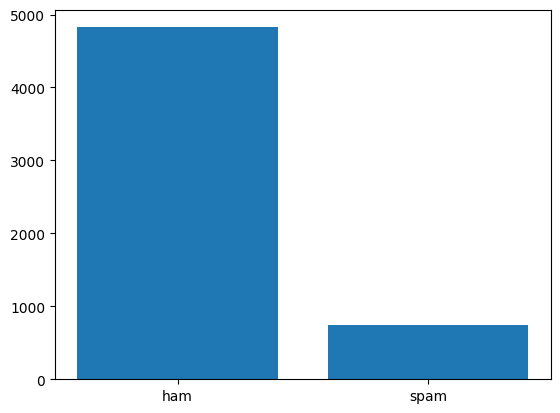

In [148]:
val_counts = data["target"].value_counts()
plt.bar(x = val_counts.index, height = val_counts.values)

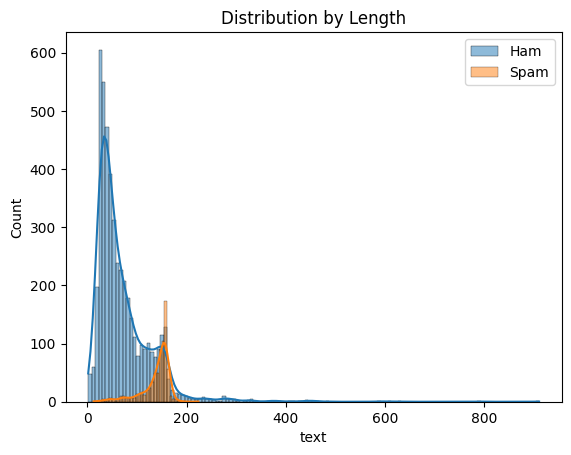

In [149]:
# plotting graph by length (count).

ham_msg_lengths = data[data['target'] == 'ham']['text'].str.len()
sns.histplot(ham_msg_lengths, label='Ham', kde=True)

spam_msg_lengths = data[data['target'] == 'spam']['text'].str.len()
sns.histplot(spam_msg_lengths, label='Spam', kde=True)

plt.title('Distribution by Length')
plt.legend()

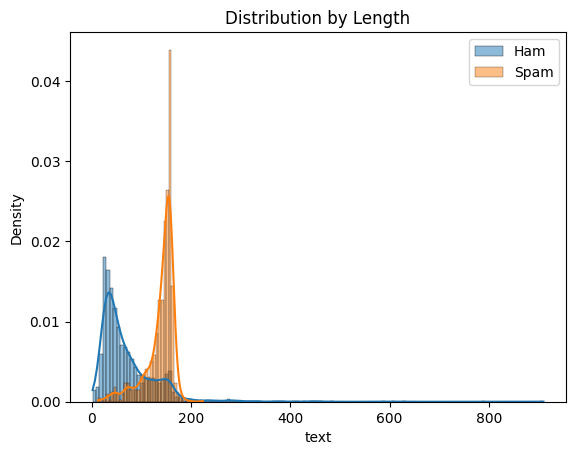

In [150]:
# plotting graph by length (density).

ham_msg_lengths = data[data['target'] == 'ham']['text'].str.len()
sns.histplot(ham_msg_lengths, label='Ham', kde=True, stat="density")

spam_msg_lengths = data[data['target'] == 'spam']['text'].str.len()
sns.histplot(spam_msg_lengths, label='Spam', kde=True, stat="density")

plt.title('Distribution by Length')
plt.legend()

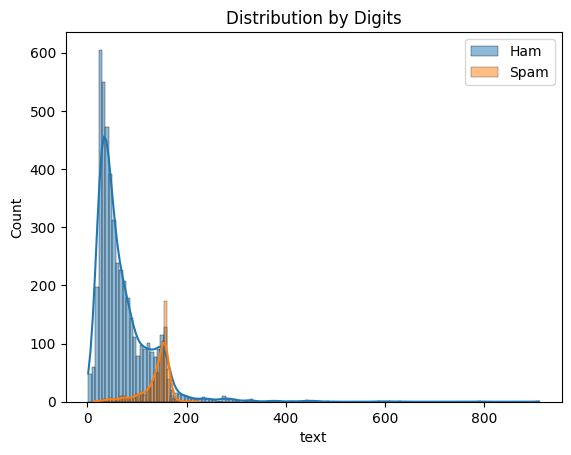

In [151]:
# plotting graph by digits (counts).

ham_digits_lengths = data[data['target'] == 'ham']['text'].str.replace(r'\D+', '').str.len()
sns.histplot(ham_digits_lengths, label='Ham', kde=True)

spam_digits_lengths = data[data['target'] == 'spam']['text'].str.replace(r'\D+', '').str.len()
sns.histplot(spam_digits_lengths, label='Spam', kde=True)

plt.title('Distribution by Digits')
plt.legend()

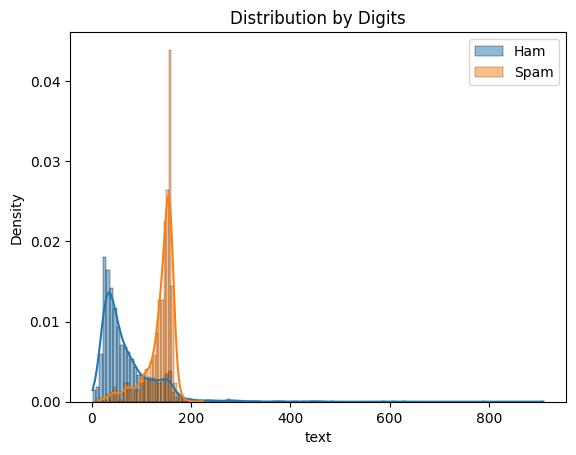

In [152]:
# plotting graph by digits (density).

ham_digits_lengths = data[data['target'] == 'ham']['text'].str.replace(r'\D+', '').str.len()
sns.histplot(ham_digits_lengths, label='Ham', kde=True, stat='density')

spam_digits_lengths = data[data['target'] == 'spam']['text'].str.replace(r'\D+', '').str.len()
sns.histplot(spam_digits_lengths, label='Spam', kde=True, stat='density')

plt.title('Distribution by Digits')
plt.legend()

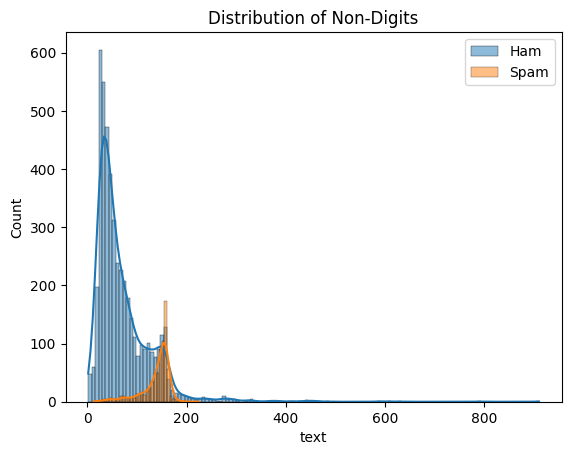

In [153]:
# plotting graph for non-digits (count).

ham_non_digits_lengths = data[data['target'] == 'ham']['text'].str.replace(r'\w+', '').str.len()
sns.histplot(ham_non_digits_lengths, label='Ham', kde=True)

spam_non_digits_lengths = data[data['target'] == 'spam']['text'].str.replace(r'\w+', '').str.len()
sns.histplot(spam_non_digits_lengths, label='Spam', kde=True)

plt.title('Distribution of Non-Digits')
plt.legend()

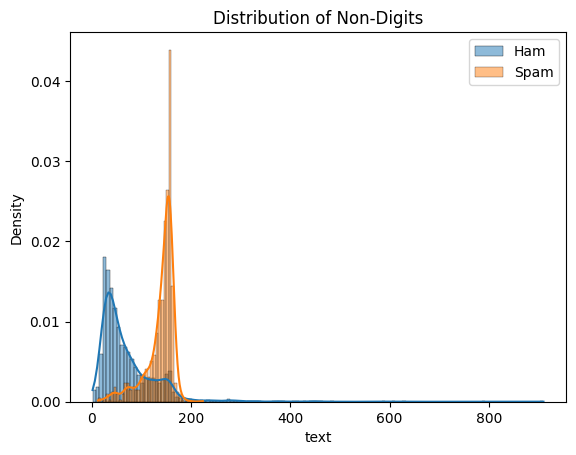

In [154]:
# plotting graph for non-digits (density).

ham_non_digits_lengths = data[data['target'] == 'ham']['text'].str.replace(r'\w+', '').str.len()
sns.histplot(ham_non_digits_lengths, label='Ham', kde=True, stat="density")

spam_non_digits_lengths = data[data['target'] == 'spam']['text'].str.replace(r'\w+', '').str.len()
sns.histplot(spam_non_digits_lengths, label='Spam', kde=True, stat="density")

plt.title('Distribution of Non-Digits')
plt.legend()

In [155]:
# for counting frequently occurence of spam and ham.

freq_count_ham = Counter(" ".join(data[data['target']=='ham']["text"]).split()).most_common(30)
data_ham = pd.DataFrame.from_dict(freq_count_ham)
data_ham = data_ham.rename(columns={0: "words of ham", 1 : "count"})

freq_count_spam = Counter(" ".join(data[data['target']=='spam']["text"]).split()).most_common(30)
data_spam = pd.DataFrame.from_dict(freq_count_spam)
data_spam = data_spam.rename(columns={0: "words of spam", 1 : "count_"})

### Graph for top 30 words of ham

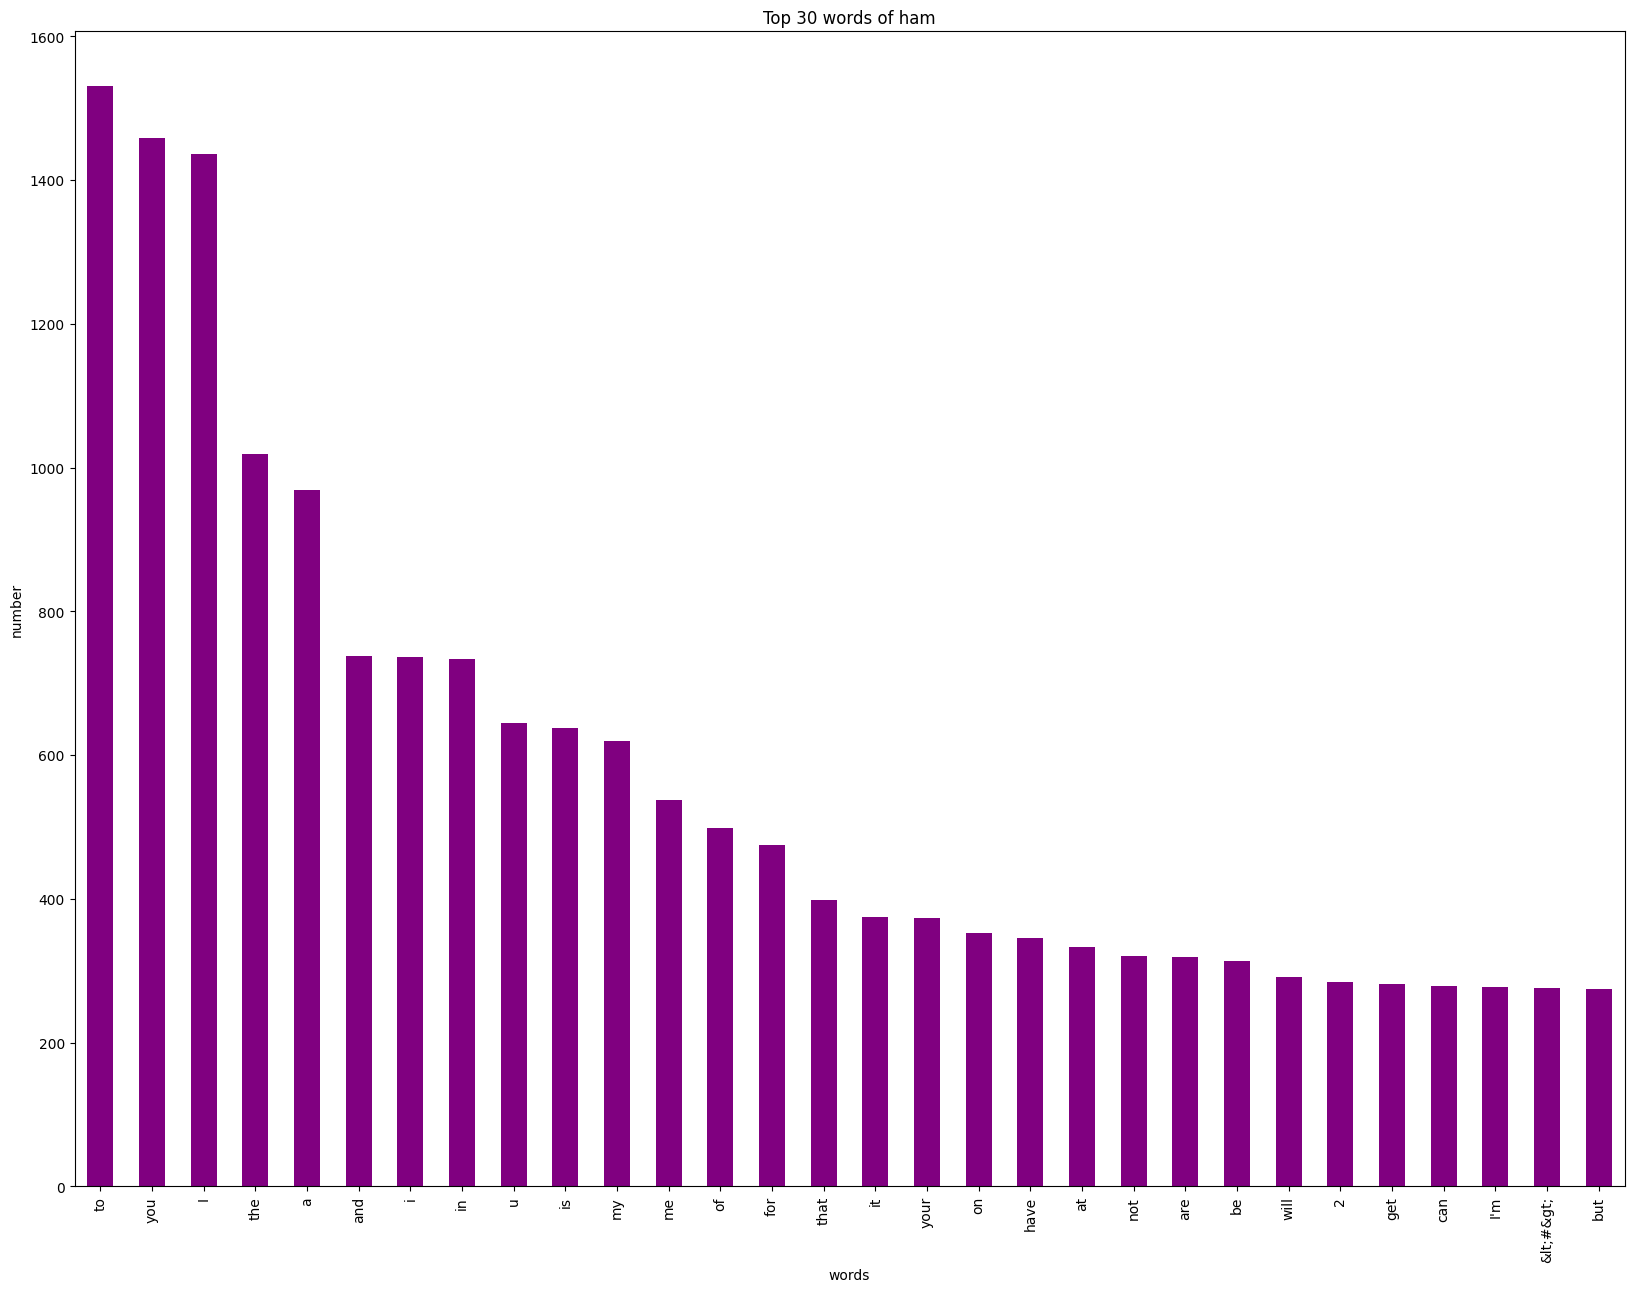

In [156]:
data_ham.plot.bar(legend = False, color = 'purple',figsize = (20,15))
y_pos = np.arange(len(data_ham["words of ham"]))
plt.xticks(y_pos, data_ham["words of ham"])
plt.title('Top 30 words of ham')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

### Graph for top 30 words of spam

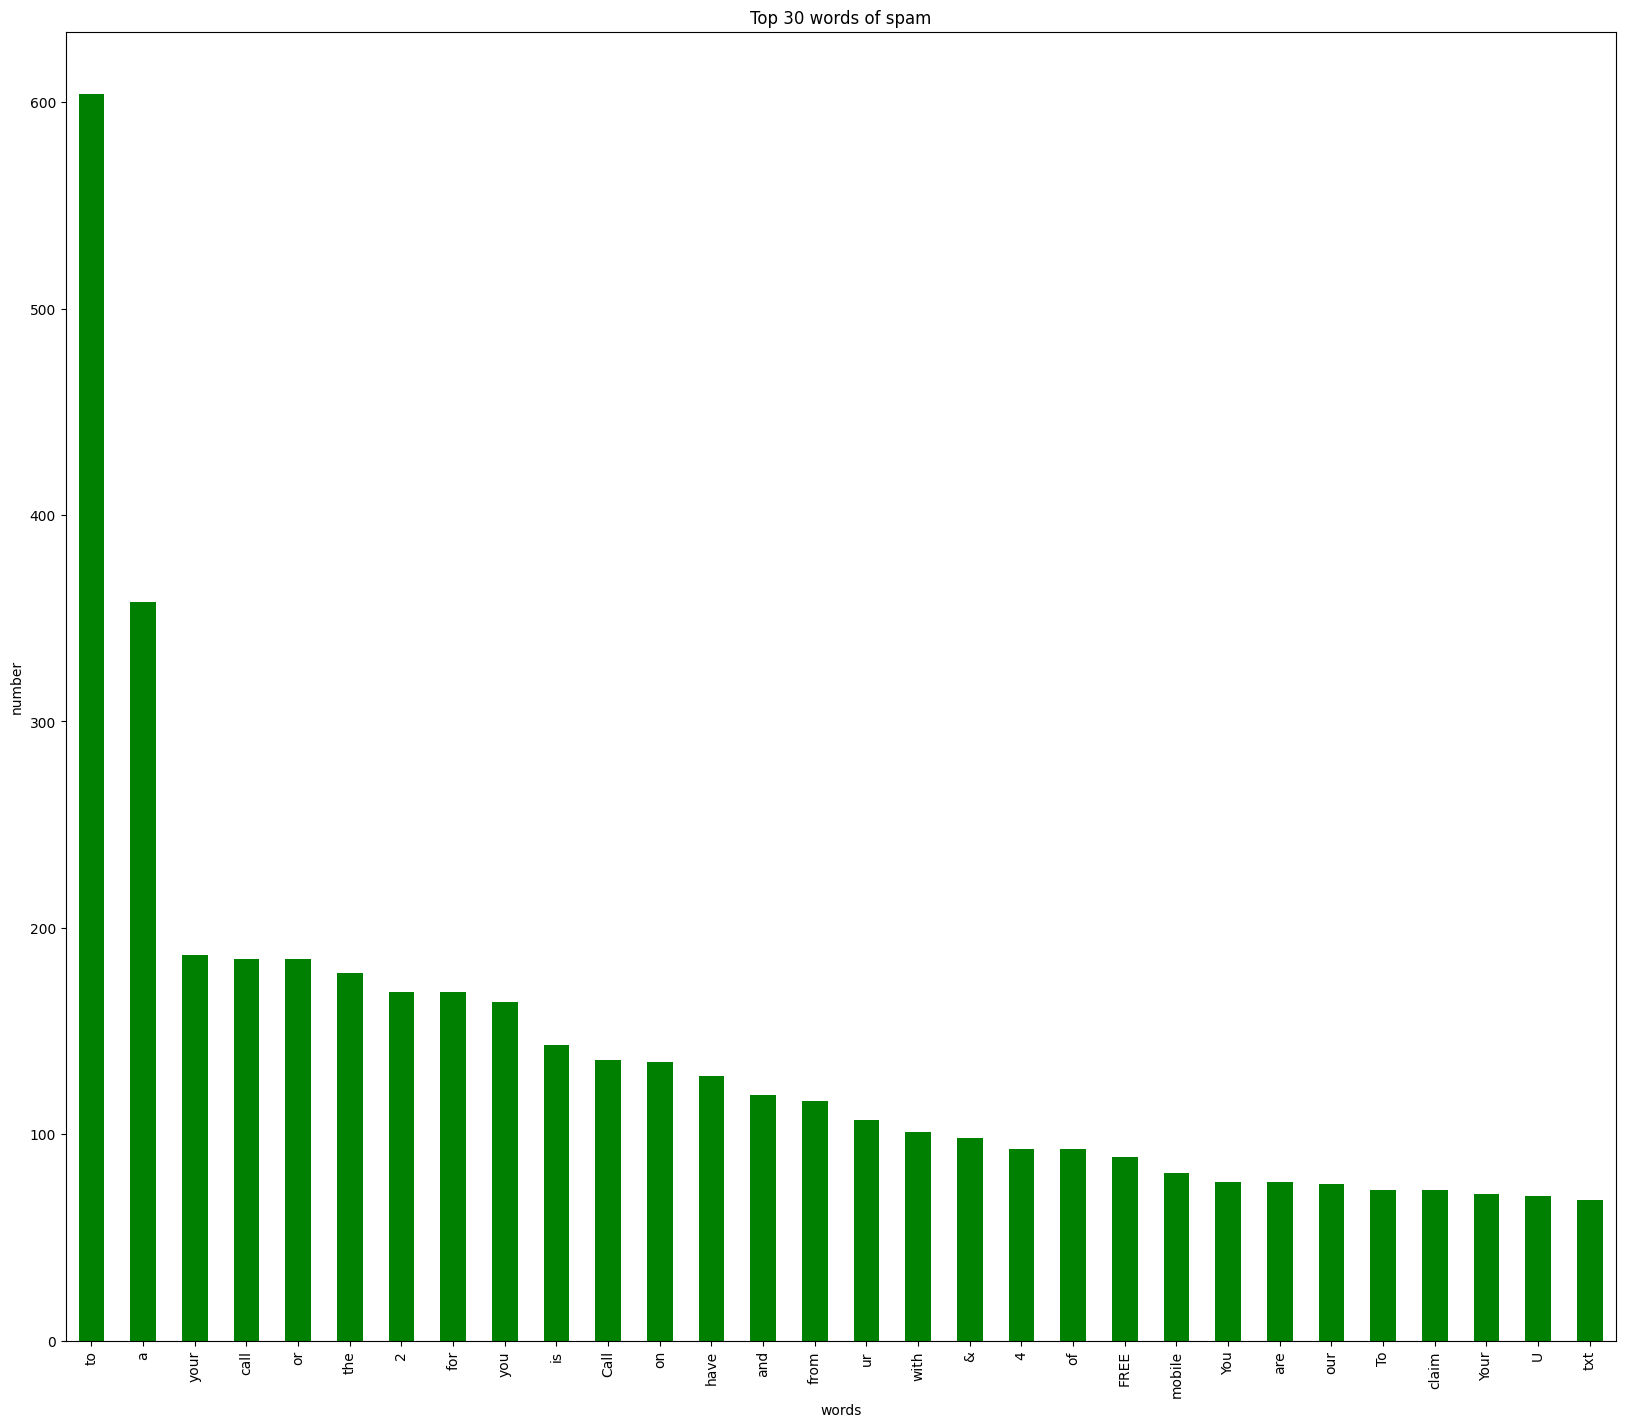

In [157]:
data_spam.plot.bar(legend = False, color = 'green', figsize = (20,17))
y_pos = np.arange(len(data_spam["words of spam"]))
plt.xticks(y_pos, data_spam["words of spam"])
plt.title('Top 30 words of spam')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

### Train-Test split

In [158]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size = 0.3, random_state = 37)

print("X_train: ", len(X_train))
print("X_test: ", len(X_test))
print("y_train: ", len(y_train))
print("y_test: ", len(y_test))

X_train:  3900
X_test:  1672
y_train:  3900
y_test:  1672


In [159]:
print(len(data))

5572


In [160]:
corpus = []
for i in range(0, len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data['text'][i]) # Remove Non-Alphabet Characters 
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    # Remove stopwords
    # Get the stems for each word
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review) # join everything again
    corpus.append(review)

In [161]:
# Convert into matrix of tokens
cv = CountVectorizer(max_features = 1500)
cv.fit(X_train)

CountVectorizer(max_features=1500)

### Making train and test count vectors

In [162]:
X_train_cv = cv.transform(X_train)
X_train_cv

<3900x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 42787 stored elements in Compressed Sparse Row format>

In [163]:
X_test_cv = cv.transform(X_test)
X_test_cv

<1672x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 18639 stored elements in Compressed Sparse Row format>

### Confusion Matrix Plotter

In [164]:
def plot_conf_mat(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

### Report Maker

In [165]:
def get_report(y_true, y_pred, model_name):
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, pos_label="spam")
    
    # Construct a single-row DataFrame with metrics
    report_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'F1 Score(+ve = spam)': [f1],
        'TP': [tp],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn]
    })
    
    return report_df

In [166]:
report = pd.DataFrame()

### NB Classifier (Uses Naive Bayes, assumes independency among features)

In [167]:
mnb = MultinomialNB(alpha = 0.5)
mnb.fit(X_train_cv,y_train)
y_mnb = mnb.predict(X_test_cv)

Naive Bayes Accuracy:  0.9826555023923444
Naive Bayes confusion_matrix:
 [[1425   15]
 [  14  218]]


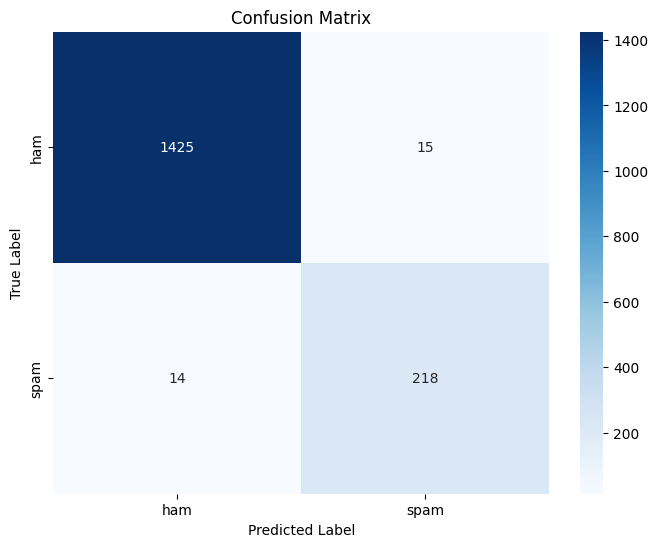

In [168]:
print('Naive Bayes Accuracy: ', accuracy_score(y_mnb , y_test))
cm = confusion_matrix(y_mnb, y_test)
print('Naive Bayes confusion_matrix:\n', cm)
plot_conf_mat(cm)

In [169]:
report = pd.concat([report, get_report(y_test, y_mnb, model_name="MultinomialNB")])
print(report)

           Model  Accuracy  F1 Score(+ve = spam)   TP    TN  FP  FN
0  MultinomialNB  0.982656              0.937634  218  1425  14  15


### SVM Classificaition

In [170]:
svc = SVC(kernel='sigmoid', gamma=1.0)
svc.fit(X_train_cv,y_train)
y_svc = svc.predict(X_test_cv)

SVM Accuracy:  0.8343301435406698
SVM confusion_matrix:
 [[1303  141]
 [ 136   92]]


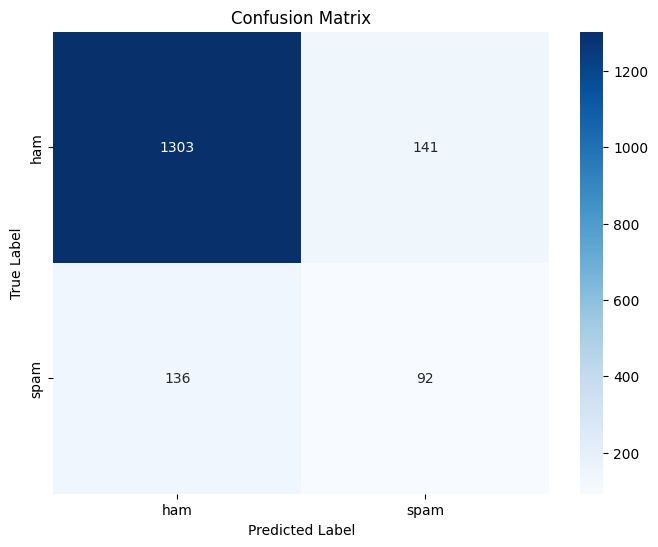

In [171]:
print('SVM Accuracy: ', accuracy_score( y_svc , y_test))
cm = confusion_matrix(y_svc, y_test)
print('SVM confusion_matrix:\n', cm)
plot_conf_mat(cm)

In [172]:
report = pd.concat([report, get_report(y_test, y_svc, model_name="SVC")])
print(report)

           Model  Accuracy  F1 Score(+ve = spam)   TP    TN   FP   FN
0  MultinomialNB  0.982656              0.937634  218  1425   14   15
0            SVC  0.834330              0.399132   92  1303  136  141


### KNN Classification

In [173]:
knc = KNeighborsClassifier(n_neighbors=100)
knc.fit(X_train_cv,y_train)

y_knc = knc.predict(X_test_cv)

KNeighbors Accuracy_score:  0.8606459330143541
KNeighbors confusion_matrix:  [[1439    0]
 [ 233    0]]


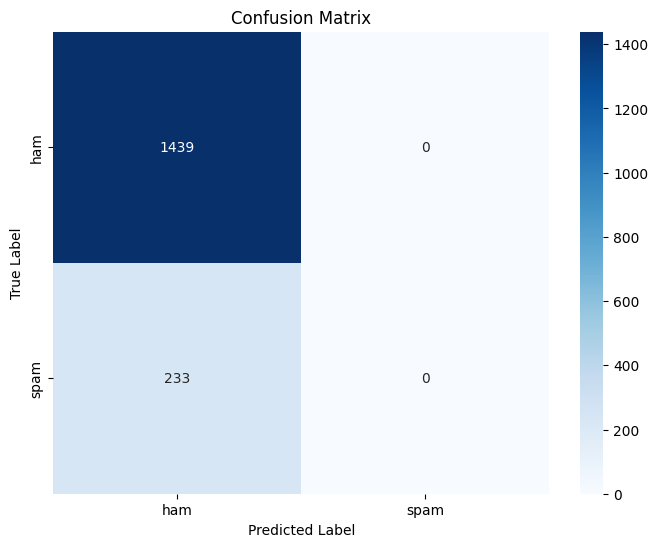

In [ ]:
print('KNeighbors Accuracy_score: ',accuracy_score(y_test,y_knc))
cm = confusion_matrix(y_test, y_knc)
print('KNeighbors confusion_matrix:\n', cm) 
plot_conf_mat(cm)

In [175]:
report = pd.concat([report, get_report(y_test, y_knc, model_name="KNN")])
print(report)

           Model  Accuracy  F1 Score(+ve = spam)   TP    TN   FP   FN
0  MultinomialNB  0.982656              0.937634  218  1425   14   15
0            SVC  0.834330              0.399132   92  1303  136  141
0            KNN  0.860646              0.000000    0  1439    0  233


### Decision Tree Classification

In [176]:
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=252)
dtc.fit(X_train_cv, y_train)

y_dtc = dtc.predict(X_test_cv)

Decision Tree Accuracy:  0.9730861244019139
Decision Tree confusion_matrix:
 [[1421   27]
 [  18  206]]


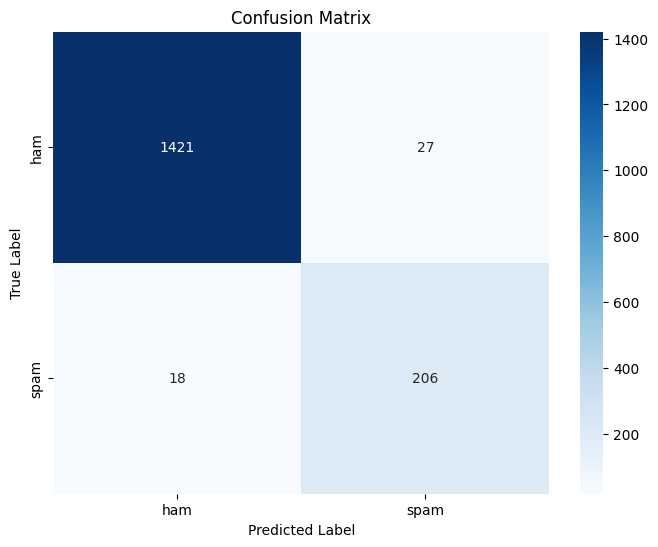

In [178]:
print('Decision Tree Accuracy: ',accuracy_score(y_test,y_dtc))
cm = confusion_matrix(y_dtc, y_test)
print('Decision Tree confusion_matrix:\n', cm)     
plot_conf_mat(cm)

In [179]:
report = pd.concat([report, get_report(y_test, y_dtc, model_name="Decision Tree")])
print(report)

           Model  Accuracy  F1 Score(+ve = spam)   TP    TN   FP   FN
0  MultinomialNB  0.982656              0.937634  218  1425   14   15
0            SVC  0.834330              0.399132   92  1303  136  141
0            KNN  0.860646              0.000000    0  1439    0  233
0  Decision Tree  0.973086              0.901532  206  1421   18   27


### Extra Tree Classification

In [180]:
etc = ExtraTreesClassifier(n_estimators=37, random_state=252)
etc.fit(X_train_cv,y_train)
y_etc = etc.predict(X_test_cv)

Extra Tree Accuracy_score:  0.9820574162679426
Extra Tree confusion_matrix:
 [[1434   25]
 [   5  208]]


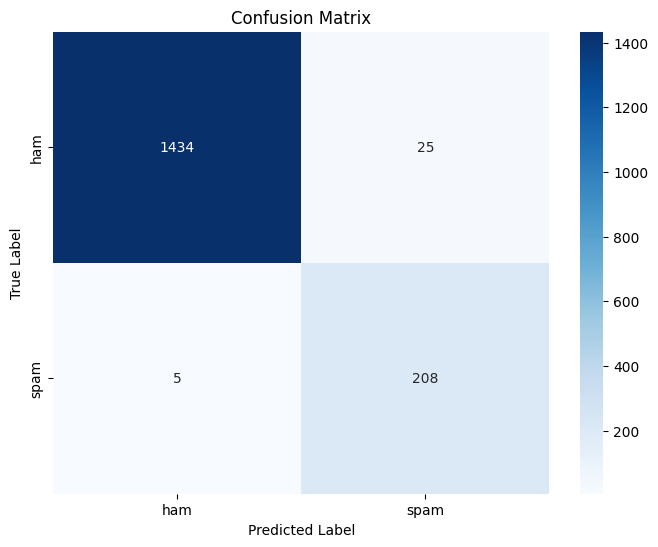

In [181]:
print('Extra Tree Accuracy_score: ',accuracy_score(y_test,y_etc))
cm = confusion_matrix(y_etc, y_test)
print('Extra Tree confusion_matrix:\n', cm) 
plot_conf_mat(cm)

In [182]:
report = pd.concat([report, get_report(y_test, y_etc, model_name="Extra Trees")])
print(report)

           Model  Accuracy  F1 Score(+ve = spam)   TP    TN   FP   FN
0  MultinomialNB  0.982656              0.937634  218  1425   14   15
0            SVC  0.834330              0.399132   92  1303  136  141
0            KNN  0.860646              0.000000    0  1439    0  233
0  Decision Tree  0.973086              0.901532  206  1421   18   27
0    Extra Trees  0.982057              0.932735  208  1434    5   25


### Random Forest Classifier

In [183]:
rfc = RandomForestClassifier(n_estimators=37, random_state=252)
rfc.fit(X_train_cv,y_train)
y_rfc = rfc.predict(X_test_cv)

Random Forest Accuracy_score:  0.9796650717703349
Random Forest confusion_matrix:
 [[1437   32]
 [   2  201]]


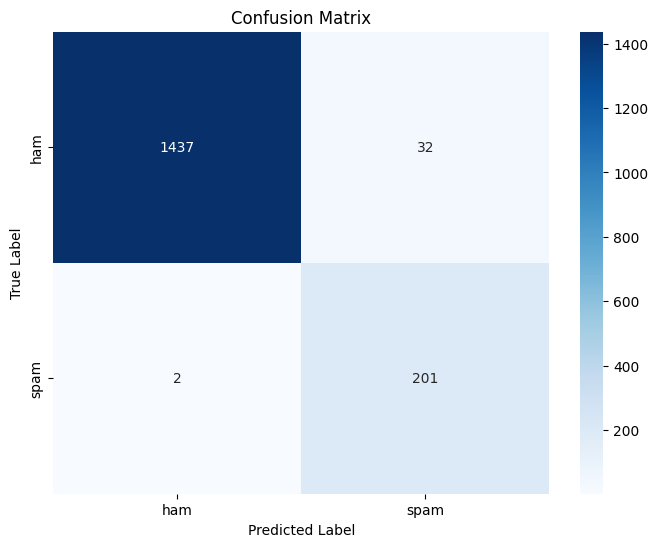

In [184]:
print('Random Forest Accuracy_score: ', accuracy_score(y_test,y_rfc))
cm = confusion_matrix(y_rfc, y_test)
print('Random Forest confusion_matrix:\n', cm) 
plot_conf_mat(cm)

In [185]:
report = pd.concat([report, get_report(y_test, y_rfc, model_name="Random Forest")])
print(report)

           Model  Accuracy  F1 Score(+ve = spam)   TP    TN   FP   FN
0  MultinomialNB  0.982656              0.937634  218  1425   14   15
0            SVC  0.834330              0.399132   92  1303  136  141
0            KNN  0.860646              0.000000    0  1439    0  233
0  Decision Tree  0.973086              0.901532  206  1421   18   27
0    Extra Trees  0.982057              0.932735  208  1434    5   25
0  Random Forest  0.979665              0.922018  201  1437    2   32


### AdaBoost (Adaptive Boost) Classifier:

In [186]:
abc = AdaBoostClassifier(n_estimators=37, random_state=252)
abc.fit(X_train_cv,y_train)
y_abc = abc.predict(X_test_cv)

AdaBoost Accuracy_score:  0.965311004784689
AdaBoost confusion_matrix:  [[1417   36]
 [  22  197]]


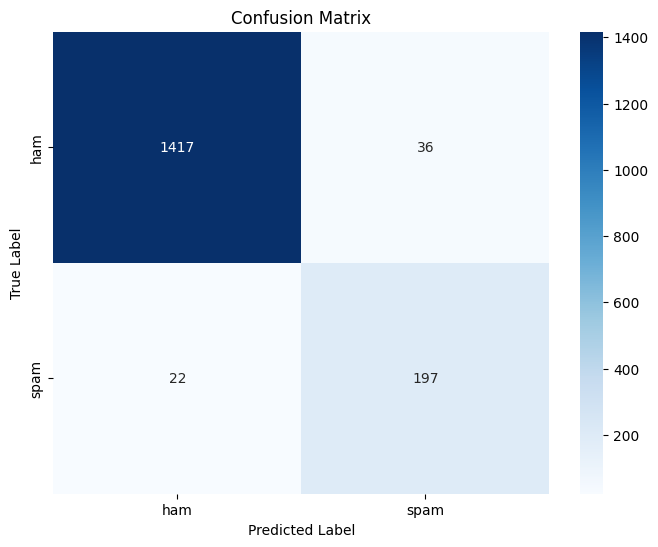

In [ ]:
print('AdaBoost Accuracy_score: ',accuracy_score(y_test,y_abc))
cm = confusion_matrix(y_abc, y_test)
print('AdaBoost confusion_matrix:\n', cm) 
plot_conf_mat(cm)

In [188]:
report = pd.concat([report, get_report(y_test, y_abc, model_name="AdaBoost")])
print(report)

           Model  Accuracy  F1 Score(+ve = spam)   TP    TN   FP   FN
0  MultinomialNB  0.982656              0.937634  218  1425   14   15
0            SVC  0.834330              0.399132   92  1303  136  141
0            KNN  0.860646              0.000000    0  1439    0  233
0  Decision Tree  0.973086              0.901532  206  1421   18   27
0    Extra Trees  0.982057              0.932735  208  1434    5   25
0  Random Forest  0.979665              0.922018  201  1437    2   32
0       AdaBoost  0.965311              0.871681  197  1417   22   36


### Bagging Classifier

In [189]:
bc = BaggingClassifier(n_estimators=9, random_state=252)
bc.fit(X_train_cv,y_train)
y_bc = bc.predict(X_test_cv)

Bagging Accuracy_score:  0.972488038277512
Bagging confusion_matrix:
 [[1420   27]
 [  19  206]]


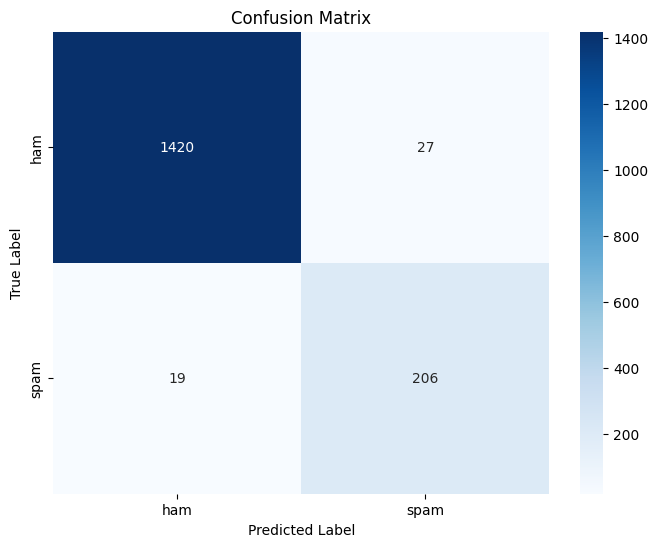

In [190]:
print('Bagging Accuracy_score: ',accuracy_score(y_test,y_bc))
cm = confusion_matrix(y_bc, y_test)
print('Bagging confusion_matrix:\n', cm)
plot_conf_mat(cm) 

In [191]:
report = pd.concat([report, get_report(y_test, y_bc, model_name="Bagging")])
print(report)

           Model  Accuracy  F1 Score(+ve = spam)   TP    TN   FP   FN
0  MultinomialNB  0.982656              0.937634  218  1425   14   15
0            SVC  0.834330              0.399132   92  1303  136  141
0            KNN  0.860646              0.000000    0  1439    0  233
0  Decision Tree  0.973086              0.901532  206  1421   18   27
0    Extra Trees  0.982057              0.932735  208  1434    5   25
0  Random Forest  0.979665              0.922018  201  1437    2   32
0       AdaBoost  0.965311              0.871681  197  1417   22   36
0        Bagging  0.972488              0.899563  206  1420   19   27
